In [1]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, torch.__version__)

cuda:0 1.9.0+cu102


In [2]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install torch-geometric
import torch_geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 3.0 MB 3.7 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 1.6 MB 8.4 MB/s 
     |████████████████████████████████| 222 kB 7.4 MB/s 
     |████████████████████████████████| 376 kB 30.9 MB/s 
     |████████████████████████████████| 45 kB 4.1 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.2-py3-none-any.whl size=388142 sha256=da931ac5ee301e7caa8b9a65e35a1a42fadc6b4cf5f347d0832175ec1a2c39d6
  Stored in directory: /root/.cache/pip/wheels/55/93/b6/2eeb0465afe89aee74d7a07a606e9770466d7565abd45a99d5
Successfully built torch-geometric


# **1) Attention Layer**

In [3]:
from torch_scatter import scatter_mean, scatter_add

# Defining the Attention Mechanism as a Separate Class of itself
class AttentionLayer(torch.nn.Module):
    def __init__(self, d = 16, activation=2, a = 0.1):
        """
        :param: d: Output Dimension of the Node Embeddings
        :param: activation: The Activation Function to be used for the Attention Layer
        :param: a: Slope of the -ve part if the activation is Leaky ReLU
        """
        super(AttentionLayer, self).__init__()
        self.d = d # Output dimension of the Convolution Vector for each Node
        self.activation = activation 
        self.a = a # Slope of the negative part in Leaky-ReLU
        
        self.params()
        self.initialize()
        
    def params(self):
        self.W_att = torch.nn.Parameter(torch.Tensor(self.d, self.d))

    def initialize(self):
        """
        Initialization depends upon the activation function used.
        If ReLU/ Leaky ReLU : He (Kaiming) Initialization
        If tanh/ sigmoid : Xavier Initialization
        0-ReLU, 1-Leaky ReLU, 2-tanh, 3-sigmoid
        """
        non_lin = {0:"relu", 1:"leaky_relu", 2:"tanh", 3:"sigmoid"}
        
        if (self.activation==1) or (self.activation==0):
            torch.nn.init.kaiming_normal_(self.W_att, a=self.a, nonlinearity=non_lin[self.activation])
        elif (self.activation==2) or (self.activation==3):
            torch.nn.init.xavier_normal_(self.W_att)
        else:
            raise ValueError("Activation can only take values 0,1,2,3!")

    def forward(self, node_embeddings, batch, size = None):
        """ 
        :param: node_embeddings :(N_B x D) Tensor containing Node Embeddings
        :param: batch : Tensor containing the Graph to which Each Node in the Batch belongs
        :param: size : Check Documentation https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/mean.html
        :return: global_graph_embedding for each graph in the batch
        """
        size = batch[-1].item()+1 if size is None else size # Gives Batch Size = B
        
        global_context = scatter_mean(node_embeddings,index = batch, dim=0, dim_size = size) # (N_B,D) -> (B,D) (mean)
        global_context = torch.matmul(global_context, self.W_att) # (B,D) x (D,D) -> (B,D)
        
        # Applying the Non-Linearity over W_att*mean(U_i), the default is tanh
        if self.activation==2:
            global_context = torch.tanh(global_context)
        elif self.activation==1:
            leaky_relu = torch.nn.LeakyReLU()
            global_context = leaky_relu(global_context)
        elif self.activation==0:
            global_context = global_context.relu()
        elif self.activation==3:
            global_context = torch.sigmoid(global_context)
        
        # Getting the attention value for each Node for a Given Graph
        e = torch.sum(node_embeddings*global_context[batch], dim=1) # (N_B,D) * (N_B,D) -> (N_B,1) (due to sum along dimension D) 
        attn_weights = e.sigmoid() # (N_B, 1)
        
        # Calculating the Global Graph Embedding
        global_graph_embedding = scatter_add(node_embeddings*attn_weights.unsqueeze(-1),
                                             index=batch, dim=0, dim_size=size) # (N_B,D) x (N_B,1) -> (B,D)
        
        return global_graph_embedding

# **2) Neural Tensor Network Layer**

In [4]:
# Defining the Neural Tensor Network Layer as a Separate Class of Itself
class NTNLayer(torch.nn.Module):
    def __init__(self, d=16, k=16, activation=0, a = 0.1):
        """
        :param: d: Input Dimension of the NTN - i.e Dimension of the Graph/ Node Embeddings
        :param: k: Output Dimension of the NTN - No. of Similarity Scores to output
        :param: activation: Activation Function to be used for the NTN - Default = ReLU
        :param: a: Slope of the negative part for a Leaky ReLU activation
        """
        super(NTNLayer, self).__init__()
        self.d = d # Input Dimension of the NTN
        self.k = k # Output dimension of the NTN
        self.a = a # Slope in case of Leaky ReLU initialization 
        self.activation = activation
        self.params()
        self.initialize()
    
    def params(self):
        self.W = torch.nn.Parameter(torch.Tensor(self.d,self.d,self.k))
        self.V = torch.nn.Parameter(torch.Tensor(self.k, 2*self.d))
        self.b = torch.nn.Parameter(torch.Tensor(self.k,1))

    def initialize(self): 
        """
        Initialization depends upon the activation function used.
        If ReLU/ Leaky ReLU : He Initialization
        If tanh/ sigmoid : Xavier Initialization
        0-ReLU, 1-Leaky ReLU, 2-tanh, 3-sigmoid
        """
        non_lin = {0:"relu", 1:"leaky_relu", 2:"tanh", 3:"sigmoid"}
        if (self.activation==1) or (self.activation==0):
            torch.nn.init.kaiming_normal_(self.W, a=self.a, nonlinearity=non_lin[self.activation])
            torch.nn.init.kaiming_normal_(self.V, a=self.a, nonlinearity=non_lin[self.activation])
            torch.nn.init.kaiming_normal_(self.b, a=self.a, nonlinearity=non_lin[self.activation])
            
        elif (self.activation==2) or (self.activation==3):
            torch.nn.init.xavier_normal_(self.W)
            torch.nn.init.xavier_normal_(self.V)
            torch.nn.init.xavier_normal_(self.b)
        
        else:
            raise ValueError("Activation can only take values 0,1,2,3!")
        
    def forward(self, h1, h2):
        """Returns 'K' Rough Similarity Scores between the Pair of Graphs
        The Neural Tensor Network (NTN) outputs 'K' similarity scores where 'K' is a hyperparameter
        :param: h1 : Graph Embedding of Graph 1 - (B,D)
        :param: h2 : Graph Embedding of Graph 2 - (B,D)
        """
        B,_ = h1.shape
        scores = torch.mm(h1, self.W.view(self.d, -1)) # (B,D) x (D, K+D) -> (B, K+D)
        scores = scores.view(B,self.d,self.k) # (B,K+D) -> (B,D,K)
        scores = (scores*h2.unsqueeze(-1)).sum(dim=1) # (B,D,K) * (B,D,1) -> (B,K)
        
        concatenated_rep = torch.cat((h1, h2), dim=1) # (B,2D)
        scores = scores + torch.mm(concatenated_rep, self.V.t()) # (B,2D) x (2D,K) -> (B,K)
        scores = scores + self.b.t() # (B,K) + (1,K) = (B,K)
        
        if self.activation==0:
            scores = scores.relu()
            return scores
        elif self.activation==1:
            leaky_relu = torch.nn.LeakyReLU()
            scores = leaky_relu(scores)
            return scores
        elif self.activation==2:
            scores = torch.tanh(scores)
            return scores
        elif self.activation==3:
            scores = torch.sigmoid(scores)
            return scores
        else:
            raise ValueError("Activation can only take values 0,1,2,3!")

# **3) SimGNN - Putting it Together**

In [5]:
# Writing the Entire SimGNN Model
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch_geometric.nn import GCNConv
from torch.nn import Linear

class SimGNN(torch.nn.Module):
    def __init__(self, num_node_features, hist=True, ntn_layer=True, d=16, k=16, bins = 16):
        super(SimGNN, self).__init__()
        self.setupHyperParams(hist, ntn_layer, d, k, bins, num_node_features)
        self.setupLayers()
        
    def setupHyperParams(self, hist, ntn_layer, d, k, bins, num_node_features):
        self.num_node_features = num_node_features
        # Dimension of the Node/ Graph Embeddding
        self.d = d
        # Output Dimension of the NTN
        self.k = k
        # Do we want to include the NTN Layer in the pipeline
        self.ntn_layer = ntn_layer
        # Do we want to use the histogram strategy
        self.hist = hist
        # No. of Bins to be used for the Histogram 
        self.bins = bins
    
    def fcnnInputDim(self):
        """Calculate The Input Dimension of the FCNN Layer"""
        if self.hist and self.ntn_layer:
            return self.bins+self.k
        elif self.hist:
            return self.bins + 1
        elif self.ntn_layer:
            return self.k
        else : 
            # Instead of NTN ,we would just be using a simple rbf kernel
            # between the Graph Embeddings to Compute Similarities
            return 1
    
    def setupLayers(self):
        fcnn_input_dim = self.fcnnInputDim()
        
        # Layers of SimGNN
        # GCN Layers
        self.conv1 = GCNConv(self.num_node_features,64)
        self.conv2 = GCNConv(64,32)
        self.conv3 = GCNConv(32,self.d)
        
        # Attention Layer and Neural Tensor Network Layer 
        self.attention_layer = AttentionLayer(self.d)
        self.NTN = NTNLayer(self.d, self.k)
        
        # Fully Connected Layer
        self.linear_1 = torch.nn.Linear(fcnn_input_dim,16)
        self.linear_2 = torch.nn.Linear(16,8)
        self.linear_3 = torch.nn.Linear(8,4)
        self.linear_4 = torch.nn.Linear(4,1)
    
    def GCN(self, x, edge_index):
        """
        Implementing the Graph Convolutional Network
        :param x : One Hot Encoded Feature Representation of the Nodes
        :param edge_index : Tensor Representation of Edges to calculate Adjacency Matrix
        :U : (N_B x D) matrix of Node Embeddings
        :N_B : Total No. of Nodes in the Batch (irrespective of parent graph) 
        :D : dimensions of the Node Embeddings (decided by us)
        I haven't implemented Dropout/ BatchNorm but can also try to do that
        """
        U = self.conv1(x, edge_index)
        U = U.relu()
        U = self.conv2(U, edge_index)
        U = U.relu()
        U = self.conv3(U, edge_index)
        return U

    def kernel(self, graph_embedding_1, graph_embedding_2):
        pass

    def rbf_kernel_sim(self, graph_embedding_1, graph_embedding_2):
        """
        :param: graph_embedding_1 : (B,D) dimensional graph embedding
        :param: graph_embedding_2 : (B,D) dimensional graph embedding
        :return: rbf_sim : RBF Kernel Similarity the two graph embeddings
        """
        distance = graph_embedding_1-graph_embedding_2
        distance = torch.sum(distance*distance, dim = 1)
        # return (1/distance).view(-1,1)
        return torch.exp(-distance).view(-1,1)
    
    def histogram(self, U1, U2, batch1, batch2):
        """ B = Batch Size
        To calculate the Histogram Representation of the Pairwise Interaction Tensor
        :param: U1 : (N_B1 x D) matrix which encodes the node embeddings of Graph 1
        :param: U2 : (N_B2 x D) matrix which encodes the node embeddings of Graph 2
        :param: batch1 : Logs the Parent graph of the Nodes
        :param: batch2 : Logs the Parent Graph of the Nodes
        :return: norm_hist_scores : (B x self.bins) Normalized histogram for each batch
        """
        # Convert U1 and U2 into Dense Matrices
        U1, mask1 = to_dense_batch(U1, batch1) # (B, N_max1, D); (B, N_max1)
        U2, mask2 = to_dense_batch(U2, batch2) # (B, N_max2, D); (B, N_max2)
        B, N_max1, _ = U1.size()
        B, N_max2, _ = U2.size()
        
        # Max Number of Nodes for Each Graph Pair in the Batch
        max_total_nodes = torch.max(mask1.sum(dim=1), mask2.sum(dim=1)).view(-1) # (B,1)
         
        # Calculating Interaction Scores for the entire batch
        interaction_scores = torch.matmul(U1, U2.permute(0,2,1)).detach() # (B, N_max1, N_max2)
        interaction_scores = torch.sigmoid(interaction_scores)

        # Getting the Histogram for each Pair in the batch
        hist_score_list = []
        for i in range(B):
            interaction_matrix = interaction_scores[:,:max_total_nodes[i], :max_total_nodes[i]]
            hist_score = torch.histc(interaction_matrix, bins = self.bins).view(-1) # (self.bins,)
            hist_score = hist_score/hist_score.sum() # Normalizing the Histogram
            hist_score_list.append(hist_score)

        return torch.stack(hist_score_list).view(B, self.bins) # (B, self.bins)
    
    def FCNN(self, x):
        """:param: x: Rough Similarity Scores of 'B' Graph Pairs where B is Batch Size"""
        ged_sim = self.linear_1(x)
        ged_sim = ged_sim.relu()
        
        ged_sim = self.linear_2(ged_sim)
        ged_sim = ged_sim.relu()
        
        ged_sim = self.linear_3(ged_sim)
        ged_sim = ged_sim.relu()
        ged_sim = self.linear_4(ged_sim)
        
        return ged_sim.sigmoid()
    
    def forward(self, data):
        """
         Forward pass with graphs.
         :param data: A Batch Containing a Pair of Graphs.
         :return score: Similarity score.
         """
        edge_index_1 = data.edge_index_1
        edge_index_2 = data.edge_index_2
        x1, x2 = data.x1, data.x2
        x1_batch , x2_batch = data.x1_batch, data.x2_batch

        # Passed through GCN
        node_embeddings_1 = self.GCN(x1, edge_index_1)
        node_embeddings_2 = self.GCN(x2, edge_index_2)

        # Passed through Attention Layer to get Graph Embedding
        graph_embedding_1 = self.attention_layer(node_embeddings_1, x1_batch)
        graph_embedding_2 = self.attention_layer(node_embeddings_2, x2_batch)
        
        # Passed through Neural Tensor Network if allowed otherwise just take a simple Inner Product
        if self.ntn_layer:
            scores = self.NTN(graph_embedding_1, graph_embedding_2)
        else:
            scores = self.rbf_kernel_sim(graph_embedding_1, graph_embedding_2)
            
        # Computed Histogram from the Node Embeddings (Strategy 2)
        if self.hist:
            hist = self.histogram(node_embeddings_1, node_embeddings_2, x1_batch, x2_batch)
            scores = torch.cat((scores, hist), dim=1) # (B, K+self.bins)

        # Pass through the Fully Connected Neural Network Layer to get Graph Edit Distance Similarity
        sim_pred = self.FCNN(scores)
        
        return sim_pred.view(-1)

# **4) Loading Data & Feature Engineering**

In [6]:
name = "LINUX"
from torch_geometric.datasets import GEDDataset
train_graphs = GEDDataset(root="./data_/train", train = True, name=name)
test_graphs = GEDDataset(root="./data_/test", train = False, name=name)

print(f"Number of Graphs in Train Set : {len(train_graphs)}")
print(f"Number of Graphs in Test Set : {len(test_graphs)}")

Extracting data_/train/raw/uc
Processing...
Done!
Extracting data_/test/raw/uc
Processing...
Done!
Number of Graphs in Train Set : 800
Number of Graphs in Test Set : 200


In [7]:
i = 1
print(train_graphs[i])
print(test_graphs[i])

Data(edge_index=[2, 8], i=[1])
Data(edge_index=[2, 14], i=[1])


## **a) Creating a Feature Matrix for the Graphs**

In [8]:
from torch_geometric.transforms import OneHotDegree
from torch_geometric.utils import degree

# If the dataset does not have a feature matrix, we create one!
# Only the AIDS700nef Dataset has an inbuilt feature matrix
# We create a One Hot Encoded Degree Feature Matrix
if train_graphs[0].x is None:
            max_degree = 0
            for graph in train_graphs + test_graphs:
                # If this graph has edges then do
                if graph.edge_index.size(1) > 0:
                    max_degree = max(max_degree, int(degree(graph.edge_index[0]).max().item()))
            
            # Create the feature matrix for the Dataset
            one_hot_degree = OneHotDegree(max_degree, cat=False)
            train_graphs.transform = one_hot_degree
            test_graphs.transform = one_hot_degree

num_node_features = train_graphs.num_features
num_edge_features = train_graphs.num_edge_features
print(num_node_features, num_edge_features)

8 0


## **b) Making Pairs of Graphs**

In [9]:
class makeGraphPairs(torch_geometric.data.Data):
    """ 
    :param: edge_index_1 : Edge Index of the First Graph
    :param: edge_index_2 : Edge Index of the Second Graph in the pair
    :param: x_1 : Feature Matrix of the First Graph in the Pair
    :param: x_2 : Feature Matrix of the Second Graph in the Pair
       
    :returns: torch_geometric.data.Data object which comprises two graphs
    """
    def __init__(self, edge_index_1, x1, edge_index_2, x2, ged, norm_ged, graph_sim):
        super(makeGraphPairs, self).__init__()
        self.edge_index_1 = edge_index_1
        self.x1 = x1
        self.edge_index_2 = edge_index_2
        self.x2 = x2
        self.ged = ged
        self.norm_ged = norm_ged
        self.graph_sim = graph_sim

    def __inc__(self, key, value):
        if key == "edge_index_1":
            return self.x1.size(0)
        elif key == "edge_index_2":
            return self.x2.size(0)
        else:
            return super().__inc__(key, value)

### **i. For Training**

In [11]:
"""TRAINING SET PAIR"""
# Data List to pass into the Data Loader to get Batches
train_graph_pair_list = []

# Making the Pairs of Graphs
for graph1_num, graph1 in enumerate(train_graphs):
    for graph2 in train_graphs:
        # Initializing Data
        edge_index_1 = graph1.edge_index
        x1 = graph1.x
        edge_index_2 = graph2.edge_index
        x2 = graph2.x
        ged = train_graphs.ged[graph1.i, graph2.i]
        norm_ged = train_graphs.norm_ged[graph1.i, graph2.i]
        graph_sim = torch.exp(-norm_ged)
        
        # Making Graph Pair
        graph_pair = makeGraphPairs(edge_index_1=edge_index_1, x1=x1, 
                                    edge_index_2=edge_index_2, x2=x2,
                                    ged=ged ,norm_ged=norm_ged, graph_sim = graph_sim)
        
        # Saving all the Graph Pairs to the List for Batching and Data Loading
        train_graph_pair_list.append(graph_pair)

### **ii. For Testing**

In [12]:
"""TEST SET PAIR"""
# Data List to pass into the Data Loader to get batches
test_graph_pair_list = []

# Making the Pairs of Graphs
for graph1 in test_graphs:
    for graph2 in train_graphs:
        # Initializing Data
        edge_index_1 = graph1.edge_index
        x1 = graph1.x
        edge_index_2 = graph2.edge_index
        x2 = graph2.x
        ged = train_graphs.ged[graph1.i, graph2.i]
        norm_ged = train_graphs.norm_ged[graph1.i, graph2.i]
        graph_sim = torch.exp(-norm_ged)
        
        # Making Graph Pair
        graph_pair = makeGraphPairs(edge_index_1=edge_index_1, x1=x1, 
                                    edge_index_2=edge_index_2, x2=x2,
                                    ged=ged ,norm_ged=norm_ged, graph_sim = graph_sim)
        
        # Saving all the Graph Pairs to the List for Batching and Data Loading
        test_graph_pair_list.append(graph_pair)

In [13]:
print("Number of Training Graph Pairs = {}".format(len(train_graph_pair_list)))
print("Number of Training Test Pairs = {}".format(len(test_graph_pair_list)))

Number of Training Graph Pairs = 640000
Number of Training Test Pairs = 160000


In [ ]:
test_graph_pair_list[1]

makeGraphPairs(edge_index_1=[2, 6], edge_index_2=[2, 8], ged=[1], graph_sim=[1], norm_ged=[1], x1=[4, 8], x2=[5, 8])

# **5) Training Begins**

In [14]:
import random

# Creating Validation Data
val_graph_pair_list = random.sample(train_graph_pair_list, len(test_graph_pair_list))
# Removing the Validation examples from Train Set
train_graph_pair_list = list(set(train_graph_pair_list)-set(val_graph_pair_list))

print("Number of Training Graph Pairs = {}".format(len(train_graph_pair_list)))
print("Number of Validation Graph Pairs = {}".format(len(val_graph_pair_list)))
print("Number of Test Graph Pairs = {}".format(len(test_graph_pair_list)))

Number of Training Graph Pairs = 480000
Number of Validation Graph Pairs = 160000
Number of Test Graph Pairs = 160000


In [15]:
from torch_geometric.data import DataLoader
test_loader = DataLoader(test_graph_pair_list, batch_size = 1024, follow_batch = ["x1", "x2"], shuffle = True)

In [16]:
from torch_geometric.data import DataLoader
batch_size = 128
train_loader = DataLoader(train_graph_pair_list, batch_size = batch_size, follow_batch = ["x1", "x2"], shuffle = True)
val_loader = DataLoader(val_graph_pair_list, batch_size = batch_size, follow_batch= ["x1", "x2"], shuffle = True)
test_loader = DataLoader(test_graph_pair_list, batch_size = 1024, follow_batch = ["x1", "x2"], shuffle = True)

In [17]:
num_batches = len(train_loader)
print(len(train_loader))

3750


In [18]:
def evaluate(dataloader, model, loss_criterion):
    total_loss = 0
    num_ex = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            sim_pred = model(data)
            batch_loss = loss_criterion(sim_pred, data.graph_sim)
            total_loss = total_loss + batch_loss*len(data.ged)
            num_ex += len(data.ged)

            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
    return total_loss.item()/num_ex

In [20]:
model = SimGNN(num_node_features, ntn_layer=True, hist=True).to(device)
loss_criterion = torch.nn.MSELoss()
opt = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 5e-6)

epochs = 7
min_val_loss = 1000
min_train_loss = 0
num_batches = len(train_loader) 

import time
import copy
from itertools import cycle
train_loss_arr = []
val_loss_arr = []
tik = time.time()

for epoch in tqdm(range(epochs), desc="Epochs"):
    model.train()
    for i, (train_batch, val_batch) in enumerate(zip(train_loader, cycle(val_loader))):
        # Training the Model
        opt.zero_grad()
        train_batch = train_batch.to(device)
        y_pred = model(train_batch)
        loss = loss_criterion(y_pred.view(-1), train_batch.graph_sim)
        loss.backward()
        opt.step()
        train_loss_arr.append(loss.item())

        #Cross Validation Begins
        model.eval()
        with torch.no_grad():
            val_batch = val_batch.to(device)
            y_val_pred = model(val_batch)
            val_loss = loss_criterion(y_val_pred.view(-1), val_batch.graph_sim)
            val_loss_arr.append(val_loss.item())
        model.train()
        
        # Model Checkpointing
        if (min_val_loss>loss.item()) and (min_val_loss>val_loss.item()):
            min_val_loss = val_loss.item()
            min_train_loss = loss.item() # Just saving this for reference
            best_model = copy.deepcopy(model.state_dict())
        
        # Printing Loss Values
        if i%200 == 0:
            print(f"Epoch{epoch+1}/{epochs} | Batch: {i}/{num_batches} | Train Loss: {loss} | Validation Loss: {val_loss}")
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache() 
    
    # Printing Epoch Summary
    print(f"Epoch: {epoch+1}/{epochs} | Train MSE: {loss} | Validation MSE: {val_loss}")

tok = time.time()

Epochs:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch1/7 | Batch: 0/3750 | Train Loss: 0.03278675675392151 | Validation Loss: 0.034326568245887756
Epoch1/7 | Batch: 300/3750 | Train Loss: 0.009013151749968529 | Validation Loss: 0.009240610525012016
Epoch1/7 | Batch: 600/3750 | Train Loss: 0.006669340655207634 | Validation Loss: 0.006871847435832024
Epoch1/7 | Batch: 900/3750 | Train Loss: 0.006431351415812969 | Validation Loss: 0.005360754672437906
Epoch1/7 | Batch: 1200/3750 | Train Loss: 0.003210979513823986 | Validation Loss: 0.00591296935454011
Epoch1/7 | Batch: 1500/3750 | Train Loss: 0.004010442644357681 | Validation Loss: 0.0032377871684730053
Epoch1/7 | Batch: 1800/3750 | Train Loss: 0.002751885913312435 | Validation Loss: 0.0020669461227953434
Epoch1/7 | Batch: 2100/3750 | Train Loss: 0.0034725614823400974 | Validation Loss: 0.001939358888193965
Epoch1/7 | Batch: 2400/3750 | Train Loss: 0.0023479594383388758 | Validation Loss: 0.0036976838018745184
Epoch1/7 | Batch: 2700/3750 | Train Loss: 0.004400455392897129 | Validation 

Epochs:  14%|█▍        | 1/7 [05:28<32:53, 328.93s/it]

Epoch: 1/7 | Train MSE: 0.0017225089250132442 | Validation MSE: 0.001607581041753292
Epoch2/7 | Batch: 0/3750 | Train Loss: 0.0022211680188775063 | Validation Loss: 0.0014292303239926696
Epoch2/7 | Batch: 300/3750 | Train Loss: 0.003005571197718382 | Validation Loss: 0.0018651967402547598
Epoch2/7 | Batch: 600/3750 | Train Loss: 0.002398404059931636 | Validation Loss: 0.0020655717235058546
Epoch2/7 | Batch: 900/3750 | Train Loss: 0.002228851430118084 | Validation Loss: 0.002371616428717971
Epoch2/7 | Batch: 1200/3750 | Train Loss: 0.0017193108797073364 | Validation Loss: 0.001791043090634048
Epoch2/7 | Batch: 1500/3750 | Train Loss: 0.0015690376749262214 | Validation Loss: 0.0016447678208351135
Epoch2/7 | Batch: 1800/3750 | Train Loss: 0.0018239018972963095 | Validation Loss: 0.0016651346813887358
Epoch2/7 | Batch: 2100/3750 | Train Loss: 0.0015804925933480263 | Validation Loss: 0.0016971636796370149
Epoch2/7 | Batch: 2400/3750 | Train Loss: 0.0019070494454354048 | Validation Loss: 0.0

Epochs:  29%|██▊       | 2/7 [10:52<27:17, 327.41s/it]

Epoch: 2/7 | Train MSE: 0.0010500111384317279 | Validation MSE: 0.0014127700123935938
Epoch3/7 | Batch: 0/3750 | Train Loss: 0.0014127623289823532 | Validation Loss: 0.0012731964234262705
Epoch3/7 | Batch: 300/3750 | Train Loss: 0.002131946850568056 | Validation Loss: 0.0011719779577106237
Epoch3/7 | Batch: 600/3750 | Train Loss: 0.0011764980154111981 | Validation Loss: 0.0010900641791522503
Epoch3/7 | Batch: 900/3750 | Train Loss: 0.0009140627807937562 | Validation Loss: 0.0008355013560503721
Epoch3/7 | Batch: 1200/3750 | Train Loss: 0.0013230452314019203 | Validation Loss: 0.0016434859717264771
Epoch3/7 | Batch: 1500/3750 | Train Loss: 0.0008646808564662933 | Validation Loss: 0.0010916328756138682
Epoch3/7 | Batch: 1800/3750 | Train Loss: 0.0015367348678410053 | Validation Loss: 0.0008421125821769238
Epoch3/7 | Batch: 2100/3750 | Train Loss: 0.001285931677557528 | Validation Loss: 0.0016194852069020271
Epoch3/7 | Batch: 2400/3750 | Train Loss: 0.0007554538315162063 | Validation Loss:

Epochs:  43%|████▎     | 3/7 [16:18<21:48, 327.00s/it]

Epoch: 3/7 | Train MSE: 0.0008731387206353247 | Validation MSE: 0.0011668183142319322
Epoch4/7 | Batch: 0/3750 | Train Loss: 0.0009672763990238309 | Validation Loss: 0.0010472660651430488
Epoch4/7 | Batch: 300/3750 | Train Loss: 0.0007060910575091839 | Validation Loss: 0.0007883164216764271
Epoch4/7 | Batch: 600/3750 | Train Loss: 0.0007604941492900252 | Validation Loss: 0.0008817848283797503
Epoch4/7 | Batch: 900/3750 | Train Loss: 0.001170661300420761 | Validation Loss: 0.0006995787844061852
Epoch4/7 | Batch: 1200/3750 | Train Loss: 0.0015811463817954063 | Validation Loss: 0.0007370223174802959
Epoch4/7 | Batch: 1500/3750 | Train Loss: 0.001324727083556354 | Validation Loss: 0.000999106909148395
Epoch4/7 | Batch: 1800/3750 | Train Loss: 0.0009308444568887353 | Validation Loss: 0.0005217466969043016
Epoch4/7 | Batch: 2100/3750 | Train Loss: 0.0006185213569551706 | Validation Loss: 0.001047021709382534
Epoch4/7 | Batch: 2400/3750 | Train Loss: 0.0007798456936143339 | Validation Loss: 0

Epochs:  57%|█████▋    | 4/7 [21:44<16:19, 326.62s/it]

Epoch: 4/7 | Train MSE: 0.0010094877798110247 | Validation MSE: 0.0009793346980586648
Epoch5/7 | Batch: 0/3750 | Train Loss: 0.0009391977800987661 | Validation Loss: 0.0011233394034206867
Epoch5/7 | Batch: 300/3750 | Train Loss: 0.0007810573442839086 | Validation Loss: 0.0006540298345498741
Epoch5/7 | Batch: 600/3750 | Train Loss: 0.0006868450436741114 | Validation Loss: 0.001045807497575879
Epoch5/7 | Batch: 900/3750 | Train Loss: 0.0013826085487380624 | Validation Loss: 0.0007707441691309214
Epoch5/7 | Batch: 1200/3750 | Train Loss: 0.0012169622350484133 | Validation Loss: 0.0008495693909935653
Epoch5/7 | Batch: 1500/3750 | Train Loss: 0.0007409242098219693 | Validation Loss: 0.0006542467162944376
Epoch5/7 | Batch: 1800/3750 | Train Loss: 0.0007984405383467674 | Validation Loss: 0.000608094094786793
Epoch5/7 | Batch: 2100/3750 | Train Loss: 0.000644552696030587 | Validation Loss: 0.0012788670137524605
Epoch5/7 | Batch: 2400/3750 | Train Loss: 0.0007334903348237276 | Validation Loss: 

Epochs:  71%|███████▏  | 5/7 [27:10<10:52, 326.37s/it]

Epoch: 5/7 | Train MSE: 0.0005352775915525854 | Validation MSE: 0.0006294577615335584
Epoch6/7 | Batch: 0/3750 | Train Loss: 0.000763817923143506 | Validation Loss: 0.0005340100033208728
Epoch6/7 | Batch: 300/3750 | Train Loss: 0.0006387820467352867 | Validation Loss: 0.0009432226070202887
Epoch6/7 | Batch: 600/3750 | Train Loss: 0.0006161160999909043 | Validation Loss: 0.0006298115476965904
Epoch6/7 | Batch: 900/3750 | Train Loss: 0.0015320872189477086 | Validation Loss: 0.0006010217475704849
Epoch6/7 | Batch: 1200/3750 | Train Loss: 0.0008970369817689061 | Validation Loss: 0.0011703020427376032
Epoch6/7 | Batch: 1500/3750 | Train Loss: 0.000642991391941905 | Validation Loss: 0.0007123446557670832
Epoch6/7 | Batch: 1800/3750 | Train Loss: 0.0006672046147286892 | Validation Loss: 0.0005879299715161324
Epoch6/7 | Batch: 2100/3750 | Train Loss: 0.000884806620888412 | Validation Loss: 0.000645429128780961
Epoch6/7 | Batch: 2400/3750 | Train Loss: 0.0011094409273937345 | Validation Loss: 0

Epochs:  86%|████████▌ | 6/7 [32:33<05:25, 325.55s/it]

Epoch: 6/7 | Train MSE: 0.0005445805727504194 | Validation MSE: 0.0006356885423883796
Epoch7/7 | Batch: 0/3750 | Train Loss: 0.0005103161092847586 | Validation Loss: 0.0007732708472758532
Epoch7/7 | Batch: 300/3750 | Train Loss: 0.0007088122656568885 | Validation Loss: 0.0006299025262705982
Epoch7/7 | Batch: 600/3750 | Train Loss: 0.0005204372573643923 | Validation Loss: 0.00047633005306124687
Epoch7/7 | Batch: 900/3750 | Train Loss: 0.0005289911641739309 | Validation Loss: 0.0003928783698938787
Epoch7/7 | Batch: 1200/3750 | Train Loss: 0.00039527344051748514 | Validation Loss: 0.0006296292413026094
Epoch7/7 | Batch: 1500/3750 | Train Loss: 0.0005651228129863739 | Validation Loss: 0.0008283949573524296
Epoch7/7 | Batch: 1800/3750 | Train Loss: 0.0006444610189646482 | Validation Loss: 0.0005474882200360298
Epoch7/7 | Batch: 2100/3750 | Train Loss: 0.00027153349947184324 | Validation Loss: 0.0006314297206699848
Epoch7/7 | Batch: 2400/3750 | Train Loss: 0.000289485149551183 | Validation L

Epochs: 100%|██████████| 7/7 [38:00<00:00, 325.73s/it]

Epoch: 7/7 | Train MSE: 0.0005666491342708468 | Validation MSE: 0.0003506544162519276


Minimum Validation Loss:  0.0002520935086067766 
Minimum Train Loss:  0.0003301297838333994
Time taken for Training = 2280.134s


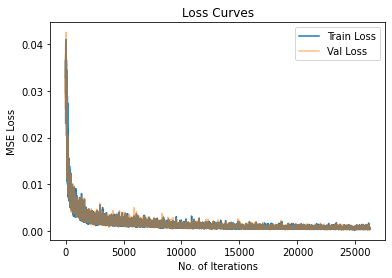

In [23]:
num = 0

print("Minimum Validation Loss: ",min_val_loss, "\nMinimum Train Loss: ", min_train_loss)
print("========================================================")
print(f"Time taken for Training = {round(tok-tik, 3)}s")
plt.plot(train_loss_arr[num:], label = "Train Loss", alpha = 1)
plt.plot(val_loss_arr[num:], label = "Val Loss", alpha = 0.5)
plt.legend()
plt.title("Loss Curves")
plt.xlabel("No. of Iterations")
plt.ylabel("MSE Loss")
plt.show()

In [24]:
# Testing the Model
model.load_state_dict(best_model)
tik = time.time() 
print(evaluate(test_loader, model, loss_criterion))
tok = time.time()
print("Test Time =",tok-tik, "s")
print("Avg. Time Per Pair =",(tok-tik)/len(test_graph_pair_list),"s")

#torch.save(model,f'simgnn-{name}.pth')

0.0005287031173706055
Test Time = 49.18877410888672 s
Avg. Time Per Pair = 0.00030742983818054197 s
